# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [1]:
import sys, os
import cs639
import torch, torchvision
import math, statistics, random, time
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["TZ"] = "US/Central"

from cs639 import reset_seed, Solver

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Load the CIFAR-10 dataset
Then, we will first load the CIFAR-10 dataset, same as knn. The utility function `get_CIFAR10_data()` in `helper_functions` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

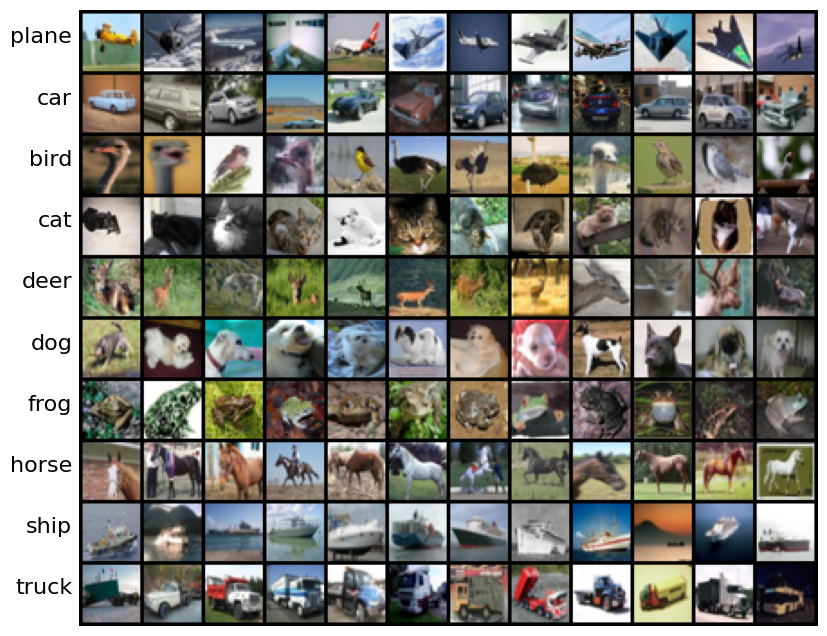

Train data shape:  torch.Size([40000, 3, 32, 32])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3, 32, 32])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


In [2]:
# Hyperparameters
validation_ratio=0.2
dtype=torch.float32

# Helper function to get CIFAR tensors
def extract_tensors(dset, num, t_dtype):
    x = torch.tensor(dset.data,
                     dtype=t_dtype).permute(0, 3, 1, 2).div_(255)
    y = torch.tensor(dset.targets, dtype=torch.int64)
    if num is not None:
        if num <= 0 or num > x.shape[0]:
            raise ValueError(
                "Invalid value num=%d; must be in the range [0, %d]"
                % (num, x.shape[0])
            )
        x = x[:num].clone()
        y = y[:num].clone()
    return x, y

# Compound X & Y training and testing tensors 
num_train=None
num_test=None
download = not os.path.isdir("cifar-10-batches-py")
dset_train = CIFAR10(root=".", download=download, train=True)
dset_test = CIFAR10(root=".", train=False)
X_train, y_train = extract_tensors(dset_train, num_train, dtype)
X_test, y_test = extract_tensors(dset_test, num_test, dtype)




# Visualize examples from the dataset.
classes = [ "plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck",]
samples_per_class = 12
samples = []
cs639.reset_seed(0)
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha="right")
    (idxs,) = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(X_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(cs639.tensor_to_image(img))
plt.axis("off")
plt.show()

# Normalize the data: subtract the mean RGB (zero mean)
mean_image = X_train.mean(dim=(0, 2, 3), keepdim=True)
X_train -= mean_image
X_test -= mean_image


# Take the validation set from the training set
num_training = int(X_train.shape[0] * (1.0 - validation_ratio))
num_validation = X_train.shape[0] - num_training

# return the dataset
data_dict = {}
data_dict["X_val"] = X_train[num_training:num_training + num_validation]
data_dict["y_val"] = y_train[num_training:num_training + num_validation]
data_dict["X_train"] = X_train[0:num_training]
data_dict["y_train"] = y_train[0:num_training]

data_dict["X_test"] = X_test
data_dict["y_test"] = y_test

#  Visualize data shapes
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

**Create Model**

In [4]:
from convolutional_networks import DeepConvNet
from fully_connected_networks import adam, sgd_momentum
reset_seed(0)

num_train = 500
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[16, 32, 32, 64, 64],
                    max_pools=[0, 1, 2, 3, 4],
                    weight_scale='kaiming',
                    batchnorm=True,
                    reg=1e-5,  dtype=torch.float32, device='cpu')

**Train Model**

In [13]:
solver = Solver(model, small_data,
                num_epochs=10, batch_size=100,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                print_every=20, device='cpu')
solver.train()

(Time 0.13 sec; Iteration 1 / 1000) loss: 1.435226
(Epoch 0 / 10) train acc: 0.508000; val_acc: 0.460400
(Time 1.66 sec; Iteration 21 / 1000) loss: 1.428654
(Time 2.33 sec; Iteration 41 / 1000) loss: 1.372652
(Time 2.98 sec; Iteration 61 / 1000) loss: 1.419595
(Time 3.60 sec; Iteration 81 / 1000) loss: 1.232620
(Epoch 1 / 10) train acc: 0.487000; val_acc: 0.470100
(Time 4.96 sec; Iteration 101 / 1000) loss: 1.528498
(Time 5.59 sec; Iteration 121 / 1000) loss: 1.423673
(Time 6.25 sec; Iteration 141 / 1000) loss: 1.244605
(Time 6.93 sec; Iteration 161 / 1000) loss: 1.423337
(Time 7.57 sec; Iteration 181 / 1000) loss: 1.110124
(Epoch 2 / 10) train acc: 0.505000; val_acc: 0.477100
(Time 9.04 sec; Iteration 201 / 1000) loss: 1.241169
(Time 9.72 sec; Iteration 221 / 1000) loss: 1.325964
(Time 10.38 sec; Iteration 241 / 1000) loss: 1.592598
(Time 11.01 sec; Iteration 261 / 1000) loss: 1.200597
(Time 11.64 sec; Iteration 281 / 1000) loss: 1.415114
(Epoch 3 / 10) train acc: 0.513000; val_acc: 0

In [17]:
from convolutional_networks import DeepConvNet
from fully_connected_networks import sgd_momentum, adam
reset_seed(0)

# Define model hyperparameters
num_train = 10000
num_classes = 10
num_filters = [8, 8, 16, 16, 32, 32]
max_pools = [1, 3, 5]
weight_scale = 'kaiming'
batchnorm = True
regularization = 1e-5

# Define solving hyperparameters
num_epochs = 15
batch_size = 128
learning_rates = [5e-2, 5e-3, 1e-2, 2e-2]
update_rule = adam # Reccomended Options: sgd_momentum, adam

# Grab data to train on based on num_train
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

bn_solvers = []
for lr in learning_rates:
  print('Normalization: learning rate = ', lr)
  bn_model = DeepConvNet(
    input_dims=input_dims, 
    num_classes=num_classes,
    num_filters=num_filters,
    max_pools=max_pools,
    weight_scale=weight_scale,
    batchnorm=batchnorm,
    reg=regularization, 
    dtype=torch.float32, device='cpu'
  )
  bn_solver = Solver(
    bn_model, 
    small_data,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    update_rule=update_rule,
    optim_config={'learning_rate': lr,},
    verbose=False, device='cpu'
    )
  bn_solver.train()
  bn_solvers.append(bn_solver)

Normalization: learning rate =  0.05


KeyboardInterrupt: 

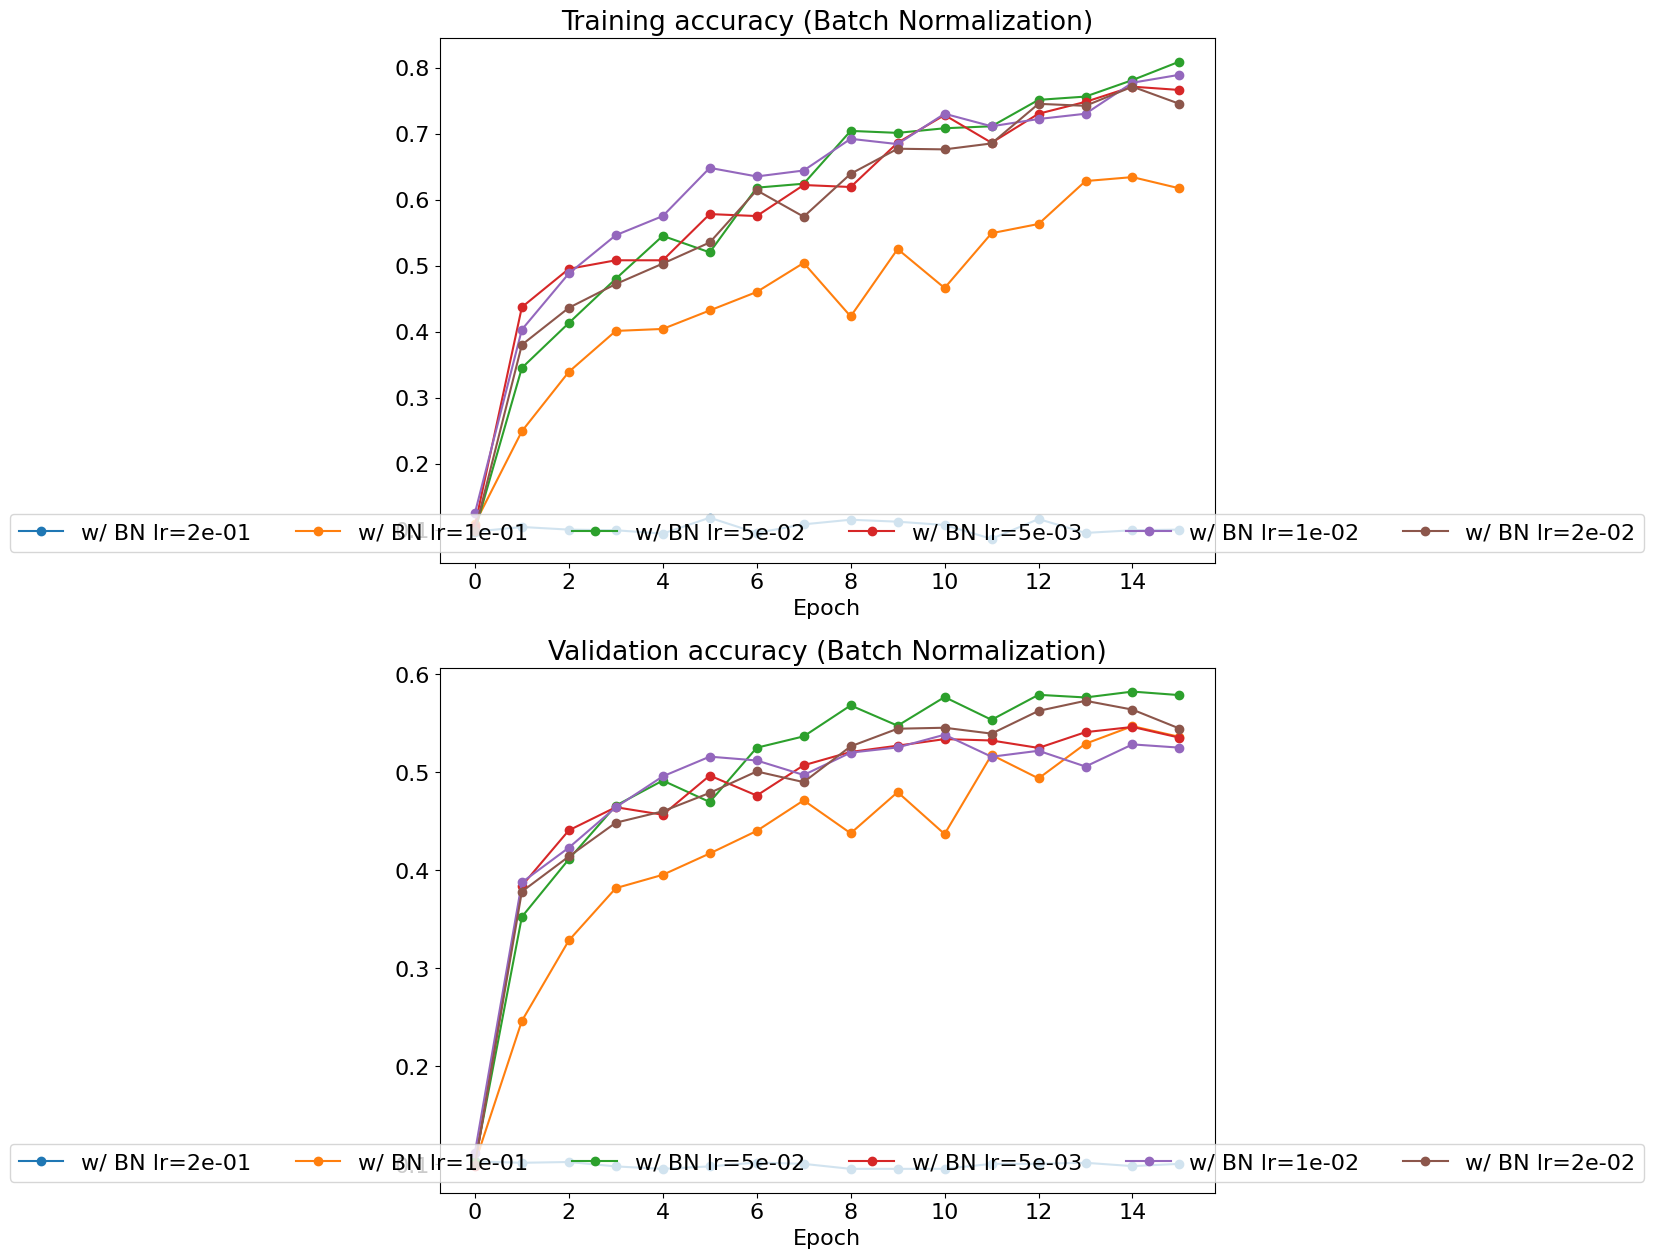

In [16]:
def plot_training_history_bn(title, label, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
  """utility function for plotting training history"""
  plt.title(title)
  plt.xlabel(label)
  bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
  num_bn = len(bn_plots)
  for i in range(num_bn):
    label='w/ BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bn_plots[i], bn_marker, label=label)
  plt.legend(loc='lower center', ncol=num_bn)

plt.subplot(2, 1, 1)
plot_training_history_bn('Training accuracy','Epoch', bn_solvers, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in learning_rates])
plt.subplot(2, 1, 2)
plot_training_history_bn('Validation accuracy','Epoch', bn_solvers, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in learning_rates])

plt.gcf().set_size_inches(10, 15)
plt.show()

**Model Visualizations**

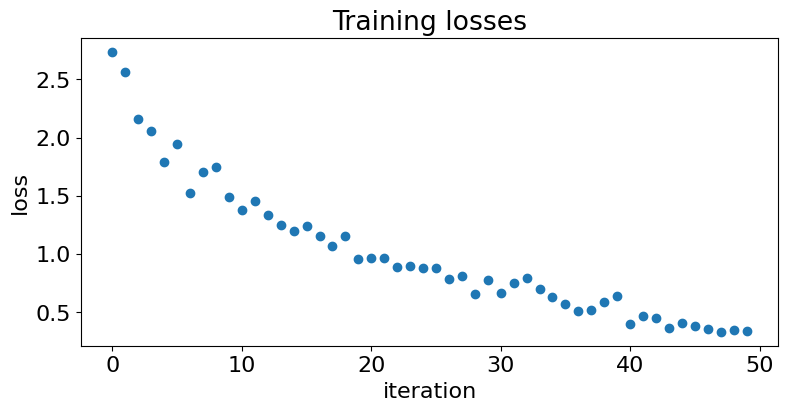

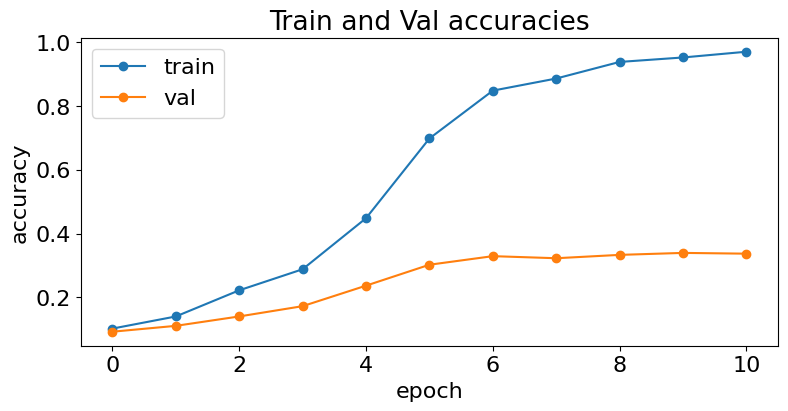

In [7]:
plt.title('Training losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Train and Val accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

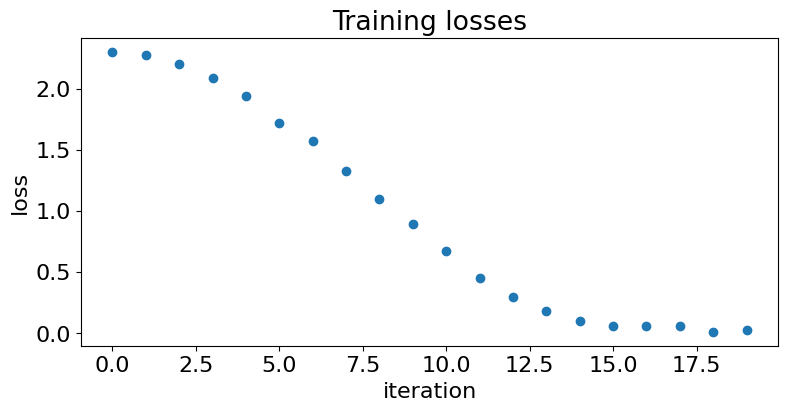

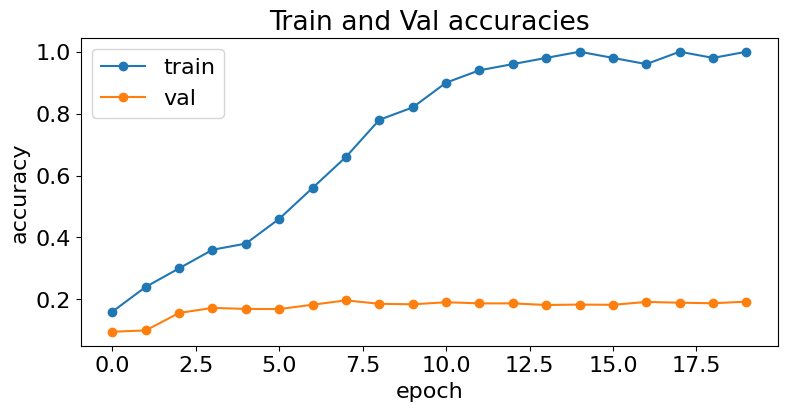

In [98]:
plt.title('Training losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Train and Val accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

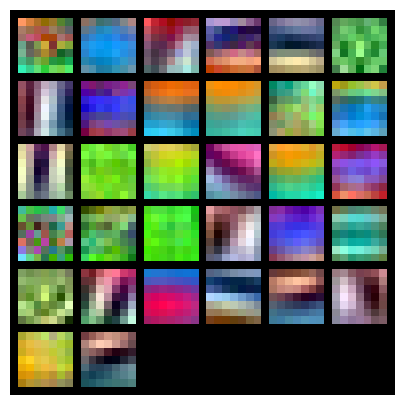

In [ ]:
from torchvision.utils import make_grid
nrow = math.ceil(math.sqrt(model.params['W1'].shape[0]))
grid = make_grid(model.params['W1'], nrow=nrow, padding=1, normalize=True, scale_each=True)
plt.imshow(grid.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Batchnorm for deep convolutional networks (2 points)
Run the following to train a deep convolutional network on a subset of 500 training examples both with and without batch normalization.

In [14]:
from convolutional_networks import DeepConvNet
from fully_connected_networks import adam, sgd_momentum
reset_seed(0)

# Try training a deep convolutional net with batchnorm
num_train = 500
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                       num_filters=[16, 32, 32, 64, 64],
                       max_pools=[0, 1, 2, 3, 4],
                       weight_scale='kaiming',
                       batchnorm=True,
                       reg=1e-5,  dtype=torch.float32, device='cpu')
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[16, 32, 32, 64, 64],
                    max_pools=[0, 1, 2, 3, 4],
                    weight_scale='kaiming',
                    batchnorm=False,
                    reg=1e-5,  dtype=torch.float32, device='cpu')

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                   num_epochs=10, batch_size=100,
                   update_rule=adam,
                   optim_config={
                     'learning_rate': 1e-3,
                   },
                   print_every=20, device='cpu')
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=100,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                print_every=20, device='cpu')
solver.train()

Solver with batch norm:
(Time 0.26 sec; Iteration 1 / 50) loss: 3.032087
(Epoch 0 / 10) train acc: 0.102000; val_acc: 0.097000
(Epoch 1 / 10) train acc: 0.164000; val_acc: 0.108800
(Epoch 2 / 10) train acc: 0.194000; val_acc: 0.129500
(Epoch 3 / 10) train acc: 0.246000; val_acc: 0.144000
(Epoch 4 / 10) train acc: 0.448000; val_acc: 0.223300
(Time 15.60 sec; Iteration 21 / 50) loss: 1.168866
(Epoch 5 / 10) train acc: 0.758000; val_acc: 0.316100
(Epoch 6 / 10) train acc: 0.846000; val_acc: 0.327800
(Epoch 7 / 10) train acc: 0.890000; val_acc: 0.334100
(Epoch 8 / 10) train acc: 0.928000; val_acc: 0.337600
(Time 28.89 sec; Iteration 41 / 50) loss: 0.491246
(Epoch 9 / 10) train acc: 0.958000; val_acc: 0.339400
(Epoch 10 / 10) train acc: 0.976000; val_acc: 0.333100

Solver without batch norm:
(Time 0.07 sec; Iteration 1 / 50) loss: 2.310765
(Epoch 0 / 10) train acc: 0.106000; val_acc: 0.097400
(Epoch 1 / 10) train acc: 0.142000; val_acc: 0.110600
(Epoch 2 / 10) train acc: 0.150000; val_acc: 

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge faster.

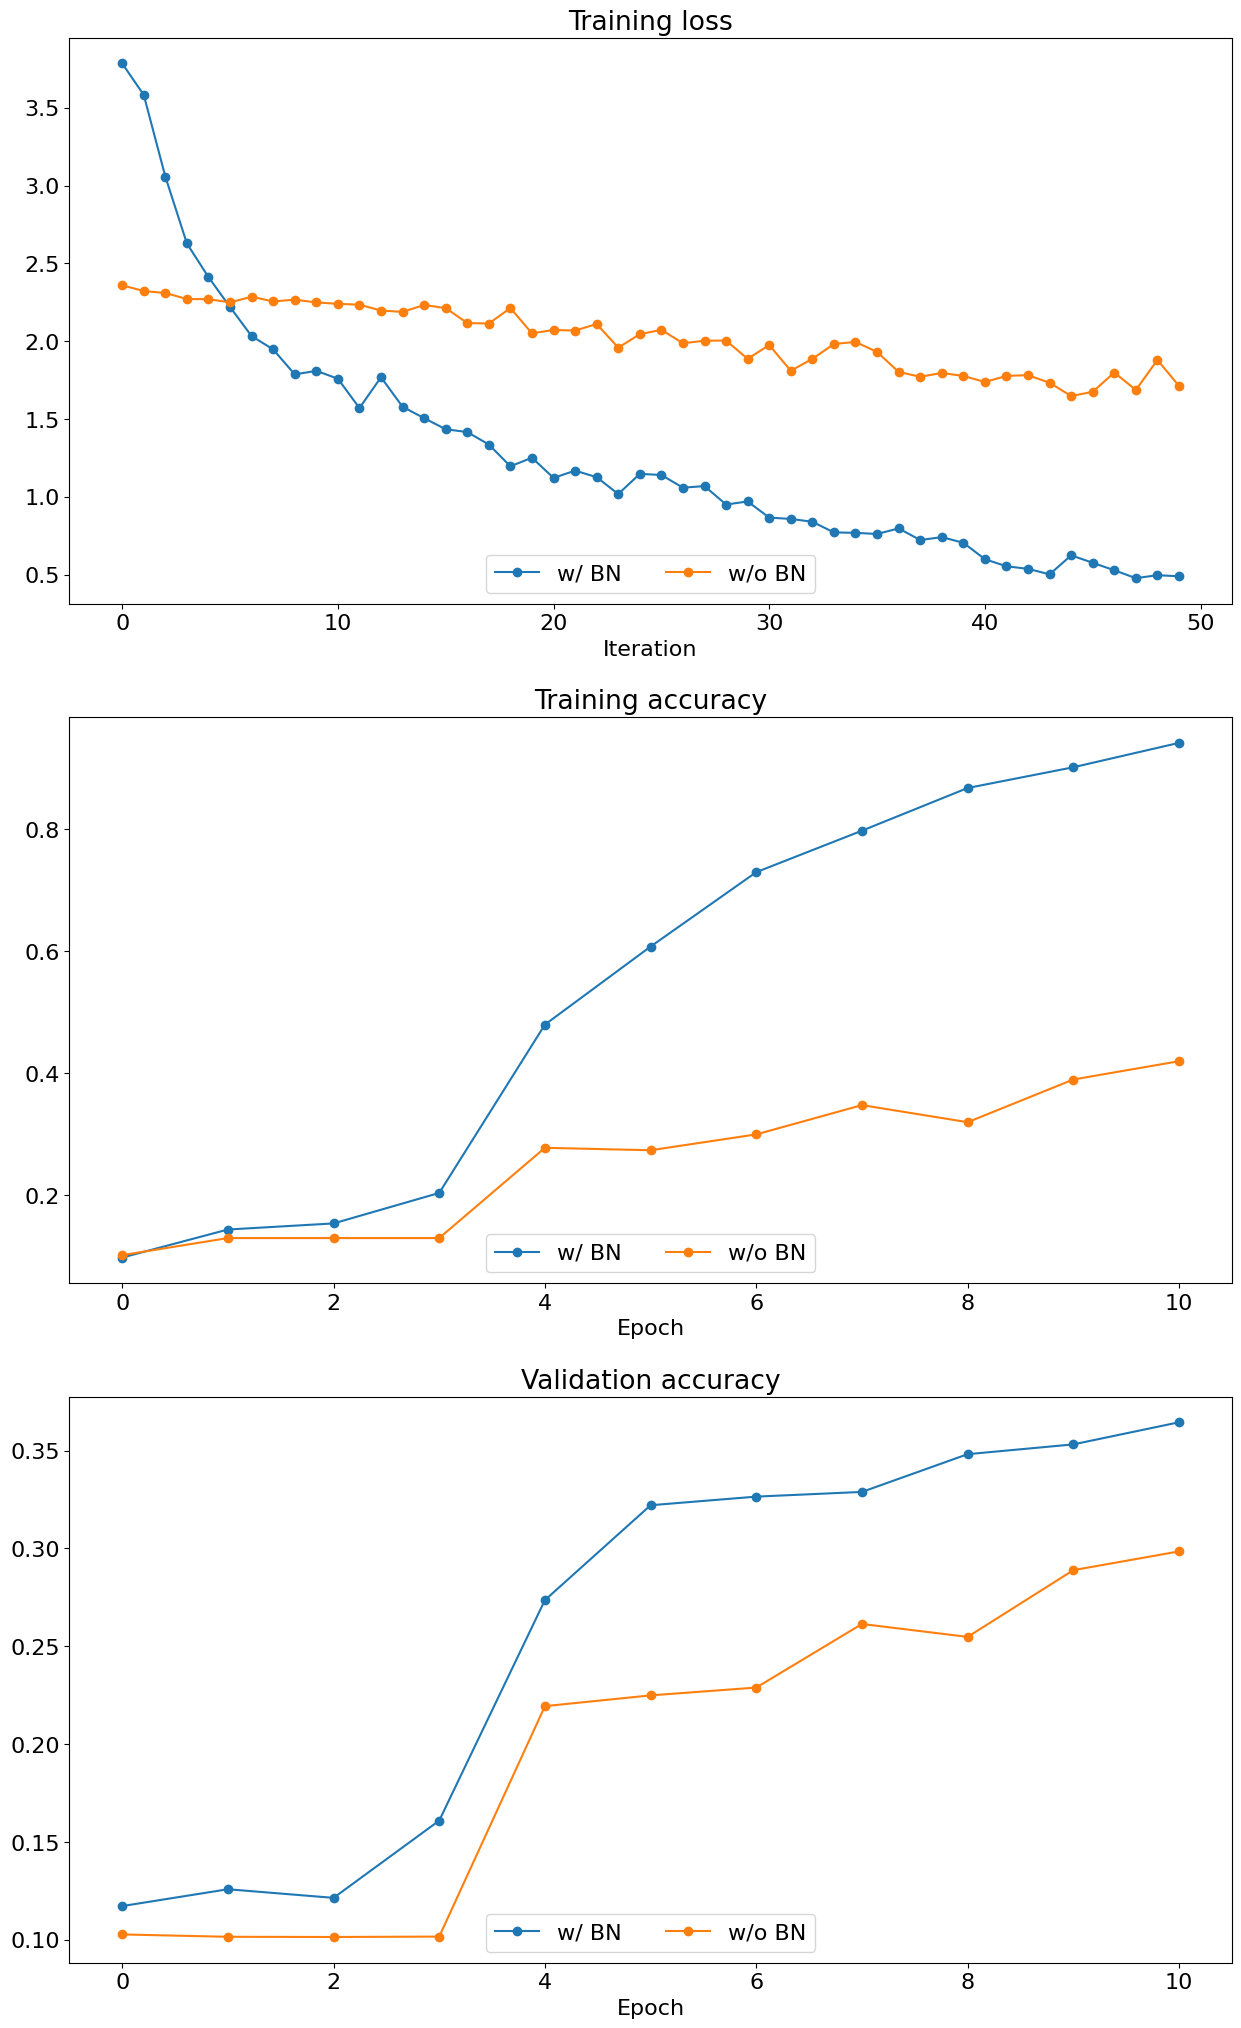

In [149]:
def plot_training_history_bn(title, label, solvers, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
  """utility function for plotting training history"""
  plt.title(title)
  plt.xlabel(label)
  bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
  bl_plots = [plot_fn(solver) for solver in solvers]
  num_bn = len(bn_plots)
  num_bl = len(bl_plots)
  for i in range(num_bn):
    label='w/ BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bn_plots[i], bn_marker, label=label)
  for i in range(num_bl):
    label='w/o BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bl_plots[i], bl_marker, label=label)
  plt.legend(loc='lower center', ncol=num_bn+num_bl)

plt.subplot(3, 1, 1)
plot_training_history_bn('Training loss','Iteration', [solver], [bn_solver], \
                      lambda x: x.loss_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 2)
plot_training_history_bn('Training accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history_bn('Validation accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 25)
plt.show()

# Batch normalization and learning rate (2 points)
We will now run a small experiment to study the interaction of batch normalization and learning rate.

The first cell will train convolutional networks with different learning rates. The second layer will plot training accuracy and validation set accuracy over time. You should find that using batch normalization helps the network to be less dependent to the learning rate. In other words, when not using batch normalization, there might be cases that certain learning rates might lead to very different performance (in terms of train/validation accuracy).  

In [1]:
from convolutional_networks import DeepConvNet
from fully_connected_networks import sgd_momentum
reset_seed(0)

# Try training a very deep net with batchnorm
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]
num_epochs = 5
lrs = [2e-1, 1e-1, 5e-2]
lrs = [5e-3, 1e-2, 2e-2]

solvers = []
for lr in lrs:
  print('No normalization: learning rate = ', lr)
  model = DeepConvNet(input_dims=input_dims, num_classes=10,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 1, 2],
                      weight_scale='kaiming',
                      batchnorm=False,
                      reg=1e-5, dtype=torch.float32, device='cpu')
  solver = Solver(model, small_data,
                  num_epochs=num_epochs, batch_size=100,
                  update_rule=sgd_momentum,
                  optim_config={
                    'learning_rate': lr,
                  },
                  verbose=False, device='cpu')
  solver.train()
  solvers.append(solver)

bn_solvers = []
for lr in lrs:
  print('Normalization: learning rate = ', lr)
  bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                         num_filters=[8, 8, 16, 16, 32, 32],
                         max_pools=[1, 3, 5],
                         weight_scale='kaiming',
                         batchnorm=True,
                         reg=1e-5, dtype=torch.float32, device='cpu')
  bn_solver = Solver(bn_model, small_data,
                     num_epochs=num_epochs, batch_size=128,
                     update_rule=sgd_momentum,
                     optim_config={
                       'learning_rate': lr,
                     },
                     verbose=False, device='cpu')
  bn_solver.train()
  bn_solvers.append(bn_solver)

NameError: name 'reset_seed' is not defined

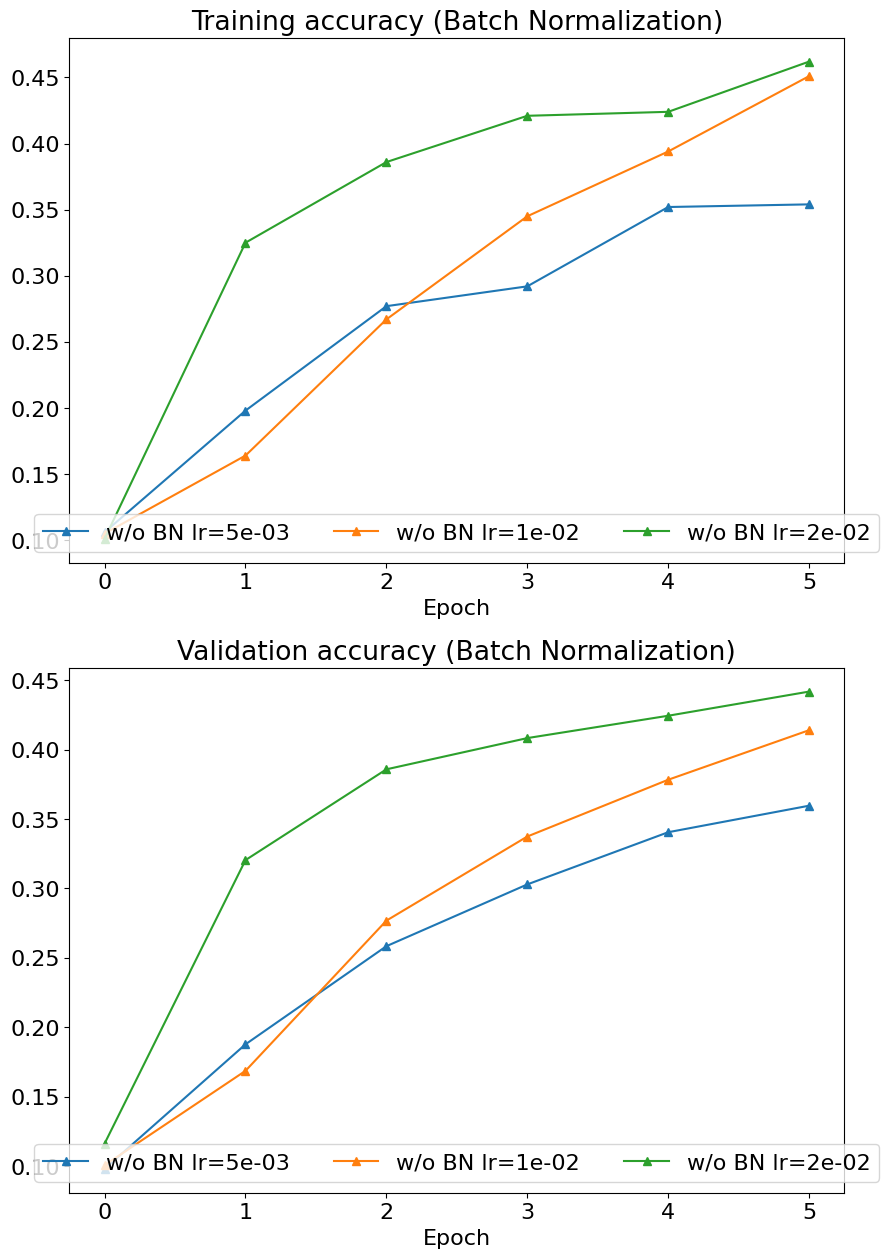

In [151]:
plt.subplot(2, 1, 1)
plot_training_history_bn('Training accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])
plt.subplot(2, 1, 2)
plot_training_history_bn('Validation accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])

plt.gcf().set_size_inches(10, 15)
plt.show()